In [1]:
%reload_ext autoreload
%autoreload 2

# The above lines reload external modules rather than needing to restart the kernel

In [21]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Circle,Polygon
from scipy.spatial import Voronoi, voronoi_plot_2d

Could we scale this by population. So the city size if a function of the population

In [4]:
# set firm variables
side_length = 1000  # city size in meters


In [24]:
def add_buildings(ax, num_buildings, side_length):
    centroids = []  # list to store centroids of buildings
    for i in range(num_buildings):
        # generate random building parameters
        x = np.random.uniform(0, side_length)
        y = np.random.uniform(0, side_length)
        width = np.random.uniform(10, 50)
        height = np.random.uniform(10, 50)
        color = np.random.rand(3)
        # add building to the city
        building = Rectangle((x, y), width, height, facecolor=color)
        # Check for overlap with existing buildings
        overlap = False
        for patch in ax.patches:
            if isinstance(patch, Rectangle):
                if (x < patch.get_x() + patch.get_width() and x + width > patch.get_x() and
                    y < patch.get_y() + patch.get_height() and y + height > patch.get_y()):
                    overlap = True
                    break
        if not overlap:
            ax.add_patch(building)
            # calculate and store the centroid
            centroid_x = x + width / 2
            centroid_y = y + height / 2
            centroids.append((centroid_x, centroid_y))
    return centroids
        
def add_circle_buildings(ax, num_circles, side_length):
    for _ in range(num_circles):
        # generate random circle parameters
        x = np.random.uniform(0, side_length)
        y = np.random.uniform(0, side_length)
        radius = np.random.uniform(5, 25)
        color = np.random.rand(3)
        # add circle to the city
        circle = Circle((x, y), radius, facecolor=color)
        # Check for overlap with existing buildings
        overlap = False
        for patch in ax.patches:
            if isinstance(patch, Rectangle) or isinstance(patch, Circle):
                if isinstance(patch, Rectangle):
                    if (x - radius < patch.get_x() + patch.get_width() and x + radius > patch.get_x() and
                        y - radius < patch.get_y() + patch.get_height() and y + radius > patch.get_y()):
                        overlap = True
                        break
                elif isinstance(patch, Circle):
                    dist = np.sqrt((x - patch.center[0])**2 + (y - patch.center[1])**2)
                    if dist < radius + patch.radius:
                        overlap = True
                        break
        if not overlap:
            ax.add_patch(circle)

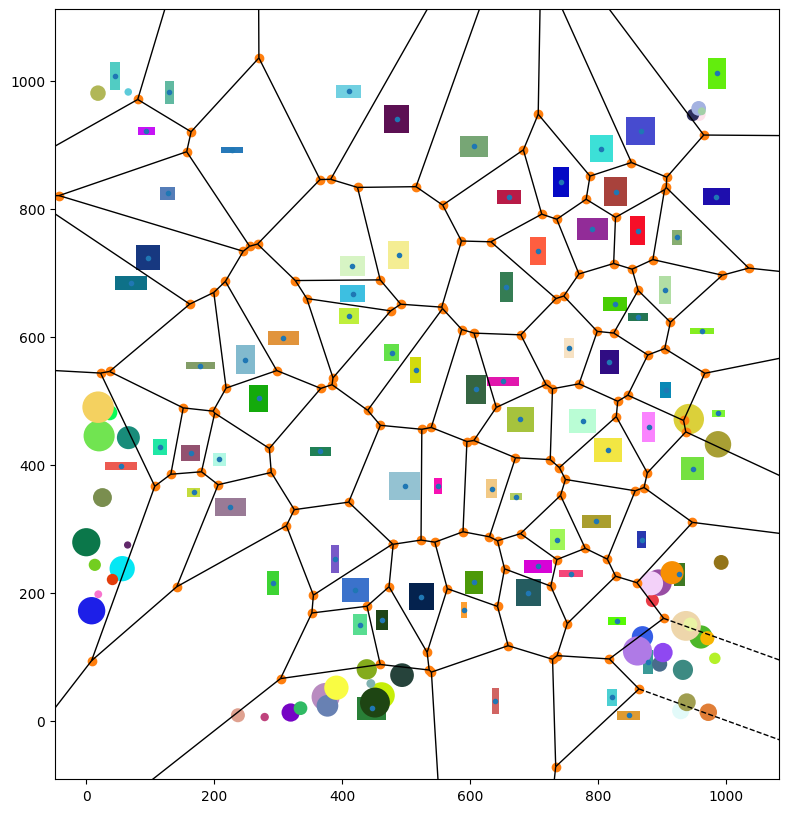

In [ ]:
ax = plt.figure(figsize=(10,10))

# create a plot
ax = plt.gca()  # get the current axes
ax.set_xlim([0, side_length])   # set the x-axis limits
ax.set_ylim([0, side_length])   # set the y-axis limits
ax.set_aspect('equal')  # make the x
centroids = add_buildings(ax, 100, side_length)
paths = Voronoi(centroids)
voronoi_plot_2d(paths, ax=ax)

plt.show()